In [182]:
%matplotlib inline
datadir='/l/necadam1/AaroBEC_data'
import qpms
from matplotlib.backends.backend_pdf import PdfPages
from qpms import Particle, CTMatrix, BaseSpec, FinitePointGroup, ScatteringSystem, TMatrixGenerator, dbgmsg_enable, dbgmsg_disable, dbgmsg_active, BesselType, EpsMu, EpsMuGenerator, lorentz_drude, ScatteringSystemCachingMode
from qpms import eV, hbar, c
from qpms.symmetries import point_group_info
import numpy as np
import time
import re
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
eh = eV/hbar
import os
import glob

def ri(z): return (z.real, z.imag)
#m = re.compile(r"([^_]+)_r([0-9.]+)nm_")
removeir = re.compile(r"_ir[^.]+.npz")
eh = eV/hbar

def iriclass(ss, fullvec):
    fullnorm = np.linalg.norm(fullvec)
    return [np.linalg.norm(ss.pack_vector(fullvec, iri))/fullnorm for iri in range(ss.nirreps)]

os.chdir(datadir)

In [47]:
def finiterectlat_scatsystem_rebuild(meta, make_posthing=True):
    Nx, Ny = meta['size']
    px, py = meta['period']
    
    #Particle positions
    orig_x = (np.arange(Nx/2) + (0 if (Nx % 2) else .5)) * px
    orig_y = (np.arange(Ny/2) + (0 if (Ny % 2) else .5)) * py

    orig_xy = np.stack(np.meshgrid(orig_x, orig_y), axis = -1)


    bspec = BaseSpec(lMax = meta['lMax'])
    medium = EpsMuGenerator(EpsMu(meta['refractive_index']**2)) 
    material = meta['material']
    if material in lorentz_drude.keys():
        foreground_emg=EpsMuGenerator(lorentz_drude[material])
    else:
        try: lemat = float(material)
        except ValueError:
            try: lemat = complex(material)
            except ValueError as ve:
                raise ValueError("--material must be either a label such as 'Ag', 'Au', or a number") from ve
        material = lemat
        foreground_emg = EpsMuGenerator(EpsMu(material**2))

    if meta['height'] is None:
        tmgen = TMatrixGenerator.sphere(medium, foreground_emg, meta['radius'])
    else:
        tmgen = TMatrixGenerator.cylinder(medium, foreground_emg, meta['radius'], meta['height'], lMax_extend = meta['lMax_extend'])

    particles= [Particle(orig_xy[i], tmgen, bspec) for i in np.ndindex(orig_xy.shape[:-1])]

    sym = FinitePointGroup(point_group_info['D2h'])
    ss, ssw = ScatteringSystem.create(particles, medium, sym, meta['centre'] * eh)
    
    if make_posthing:
        nelem = len(bspec)
        positions = ss.positions
        xpositions = np.unique(positions[:,0])
        assert(len(xpositions) == Nx)
        ypositions = np.unique(positions[:,1])
        assert(len(ypositions == Ny))
        # particle positions as integer indices
        posmap = np.empty((positions.shape[0],2), dtype=int)
        for i, pos in enumerate(positions):
            posmap[i,0] = np.searchsorted(xpositions, positions[i,0])
            posmap[i,1] = np.searchsorted(ypositions, positions[i,1])
        return (ss, bspec, Nx, Ny, px, py, posmap,)
    else:
        return ss
    
def fullvec2grid(posthing, fullvec):
    ss, bspec, Nx, Ny, px, py, posmap = posthing
    nelem = len(bspec)
    arr = np.empty((Nx,Ny,nelem), dtype=complex)
    for pi, offset in enumerate(ss.fullvec_poffsets):
        ix, iy = posmap[pi]
        arr[ix, iy] = fullvec[offset:offset+nelem]
    return arr
    

In [270]:
allfiles=glob.glob('cyl*cn*_ir*.npz')
allgraphs=dict()
for f in allfiles:
    base = removeir.sub('', f)
    if base in allgraphs.keys():
        allgraphs[base] += 1
    else:
        allgraphs[base] = 1
for k in sorted(allgraphs.keys()):
    print(k.encode('utf-8', 'surrogateescape').decode('utf-8'), allgraphs[k])

cyl_r50nm_h50nm_p570nmx620nm_10x10_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn1000 8
cyl_r50nm_h50nm_p570nmx620nm_10x10_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn150 1
cyl_r50nm_h50nm_p570nmx620nm_10x10_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn2000 8
cyl_r50nm_h50nm_p570nmx620nm_10x10_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn500 8
cyl_r50nm_h50nm_p570nmx620nm_10x10_mAu_n1.52_L2_c((1.431028+0j)±0.05±0.05j)eV_cn150 1
cyl_r50nm_h50nm_p570nmx620nm_17x13_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn500 8
cyl_r50nm_h50nm_p570nmx620nm_17x13_mAu_n1.52_L2_c((1.431027-0.05j)±0.1±0.1j)eV_cn1500 8
cyl_r50nm_h50nm_p570nmx620nm_20x20_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn1000 8
cyl_r50nm_h50nm_p570nmx620nm_20x20_mAu_n1.52_L3_c((1.431027+0j)±0.05±0.05j)eV_cn1000 8
cyl_r50nm_h50nm_p570nmx620nm_25x25_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn1000 8
cyl_r50nm_h50nm_p570nmx620nm_30x30_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn1000 8
cyl_r50nm_h50nm_p570nmx620nm_5x5_mAu_n1.52_L2_

In [319]:
filenames=sorted(glob.glob('cyl_*30x30*L2*cn1000*.npz'))
filename_prefix=removeir.sub('', filenames[0])
plotdata = {}
print(filename_prefix, len(filenames))

cyl_r50nm_h50nm_p570nmx620nm_30x30_mAu_n1.52_L2_c((1.431027+0j)±0.05±0.05j)eV_cn1000 8


In [320]:
file = filenames[0]
dat = np.load(file, allow_pickle=True)
meta=dat['meta'][()]
basicdata0=(meta['lMax'], tuple(meta['size'])) # this will be checked along
posthing = finiterectlat_scatsystem_rebuild(meta)
ss, bspec, Nx, Ny, px, py, _  = posthing
nelem = len(bspec)

In [327]:
res_thr = 3e-2

plotrecords = [None]*ss.nirreps

for file in filenames:
    dat = np.load(file, allow_pickle=True)
    meta = dat['meta'][()]
    assert(basicdata0==(meta['lMax'], tuple(meta['size'])))
    iri = dat['iri']
    valid = dat['residuals'] < res_thr
    iris.extend([iri]*sum(valid))
    eigvalv=dat['eigval'][valid]
    eigvecv=dat['eigvec'][valid]
    residv =dat['residuals'][valid]
    plotrecords_iri = []
    for i, eigval in enumerate(eigvalv):
        fulvec_beyn=ss.unpack_vector(eigvecv[i],iri)
        vecgrid = fullvec2grid(posthing,fulvec_beyn)
        vecgrid_ff = np.fft.fft2(vecgrid, axes=(0,1))

        # try to determine k-vector
        ysum = np.sum(abs(vecgrid_ff), axis=(1,2))
        xsum = np.sum(abs(vecgrid_ff), axis=(0,2))
        kxmax = np.amax(ysum)
        kymax = np.amax(xsum)
        kxidx = np.arange(Nx)[np.isclose(kxmax, ysum)]
        kyidx = np.arange(Ny)[np.isclose(kymax, xsum)]
        # we want it symmetric around zero, not N/2
        kxidx[kxidx > Nx / 2] -= Nx
        kyidx[kyidx > Ny / 2] -= Ny
        kx = kxidx * 2 * np.pi / Nx / px
        ky = kyidx * 2 * np.pi / Ny / py
        plotrecords_iri.append((eigval, residv[i], kx, ky))
    plotrecords[iri] = plotrecords_iri
        
    print(iri, sum(valid), "%g"%dat['ranktest_SV'][0])
    
markerdict = {
    0: "s",
    1: "+",
    2: "^",
    3: "v",
    4: 'x',
    5: '+',
    6: 'o',
    7: 'd',
}

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colordict = {i: colors[i] for i in range(8)}

def markerfun(b):
    b=int(b)
    if b in markerdict.keys():
        return markerdict[b]
    else: return 'X'

def colorfun(b):
    if (b+1) in colordict.keys():
        return colordict[b+1]
    else: return colordict[0]

0 66 1.30117e+18
1 50 3.86955e+17
2 66 1.89172e+18
3 50 6.73907e+17
4 66 2.07169e+18
5 51 6.35474e+17
6 67 1.12709e+18
7 50 1.81077e+18


In [328]:
pkx = 2 * np.pi / px
pky = 2 * np.pi / py
kxline = np.linspace((-pkx/2,0), (pkx/2,0))
kyline = np.linspace((0,-pky/2), (0,pky/2))
def kline_freqs(kline, int_centre, refindex):
    centre = np.array(int_centre) * np.array((pkx, pky))
    return np.linalg.norm(kline-centre, axis=-1) * c / refindex

In [342]:
pp = PdfPages(filename_prefix+'_thr%g.pdf'%res_thr)

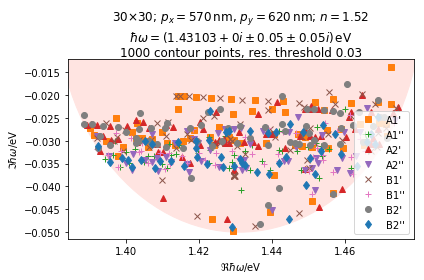

In [343]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.add_artist(matplotlib.patches.Ellipse(ri(meta['centre']), 2*meta['ar'], 2*meta['ai'], color='mistyrose'))
for iri, records_iri in enumerate(plotrecords):
    if(len(records_iri)): # skip empty irreps
        eigval, residv, kx, ky = zip(*records_iri)
        eigval_r = [e.real/eh for e in eigval]
        eigval_i = [e.imag/eh for e in eigval]
        ax.plot(eigval_r, eigval_i, marker= markerfun(iri), color=colorfun(iri), ls='', label=ss.irrep_names[iri])
ax.legend() ;
ax.set_xlabel('$\Re\hbar\omega/\mathrm{eV}$')
ax.set_ylabel('$\Im\hbar\omega/\mathrm{eV}$')
ax.set_title('''%d×%d; $p_x =%g\,\mathrm{nm}$, $p_y = %g\,\mathrm{nm}$; $n=%g$
$\hbar\omega=(%g %+g i \pm %g \pm %g i)\,\mathrm{eV}$
%d contour points, res. threshold %.2g''' % 
             (Nx, Ny, px*1e9, py*1e9, meta['refractive_index'],
              meta['centre'].real, meta['centre'].imag, meta['ar'], meta['ai'],
             meta['N'], res_thr))
plt.tight_layout()
if pp._file is not None: pp.savefig()

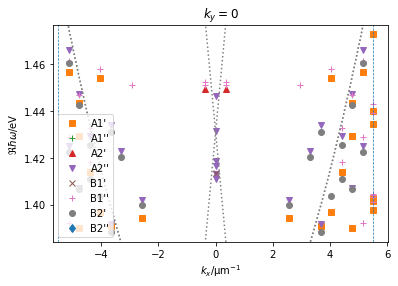

In [344]:
fig = plt.figure()
ax = fig.add_subplot(111)
for iri, records_iri in enumerate(plotrecords):
    if(len(records_iri)): # skip empty irreps
        eigval_rs = []
        kxs = []
        for rec in records_iri:      
            eigval, residv, kx, ky = rec
            if(np.all(ky==0)):
                eigval_r = eigval.real/eh
                for kx_ in kx:
                    kxs.append(kx_/1e6)
                    eigval_rs.append(eigval_r)

        ax.plot(kxs, eigval_rs, marker= markerfun(iri), color=colorfun(iri), ls='', label=ss.irrep_names[iri])
xlim = ax.set_xlim(ax.get_xlim())
ylim = ax.set_ylim(ax.get_ylim())
for lecentre in [(1,0), (-1,0), (0,1), (0,-1), (1,1), (-1,1)]:
    ax.plot(kxline[:,0]/1e6, kline_freqs(kxline,lecentre,meta['refractive_index'])/eh, color='gray', ls=':')
ax.legend(loc='lower left')
ax.set_ylabel('$\Re\hbar\omega/\mathrm{eV}$')
ax.set_xlabel('$k_x/\mathrm{\mu m}^{-1}$')
ax.set_title('$k_y=0$')
ax.axvline(pkx/2/1e6, ls='--',lw=.7)
ax.axvline(-pkx/2/1e6, ls='--',lw=.7)
if pp._file is not None:  pp.savefig()

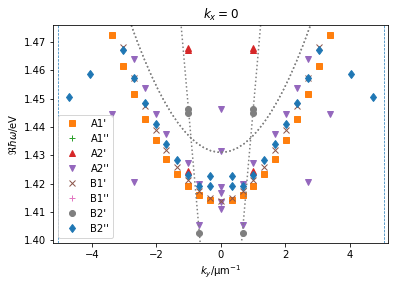

In [345]:
fig = plt.figure()
ax = fig.add_subplot(111)
for iri, records_iri in enumerate(plotrecords):
    if(len(records_iri)): # skip empty irreps
        eigval_rs = []
        kys = []
        for rec in records_iri:      
            eigval, residv, kx, ky = rec
            if(np.all(kx==0)):
                eigval_r = eigval.real/eh
                for ky_ in ky:
                    kys.append(ky_/1e6)
                    eigval_rs.append(eigval_r)

        ax.plot(kys, eigval_rs, marker= markerfun(iri), color=colorfun(iri), ls='', label=ss.irrep_names[iri])
xlim = ax.set_xlim(ax.get_xlim())
ylim = ax.set_ylim(ax.get_ylim())
for lecentre in  [(1,0), (-1,0), (0,1), (0,-1), (1,1), (-1,1)]:
    ax.plot(kyline[:,1]/1e6, kline_freqs(kyline,lecentre,meta['refractive_index'])/eh, color='gray', ls=':')
ax.legend(loc='lower left')
ax.set_ylabel('$\Re\hbar\omega/\mathrm{eV}$')
ax.set_xlabel('$k_y/\mathrm{\mu m}^{-1}$')
ax.set_title('$k_x=0$')
ax.axvline(pky/2/1e6, ls='--',lw=.7)
ax.axvline(-pky/2/1e6, ls='--',lw=.7)
if pp._file is not None: 
    pp.savefig()
    pp.close()